In [1]:
import keras
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.layers import Input, Activation, Dense, Dropout, Flatten, Conv2D,\
                        BatchNormalization, Concatenate, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.utils import plot_model

from src.analysis_tools import plot_confusion_matrix
from src.cnn_models import simple_cnn, dense_cnn, coeff_determination, rmse


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dates = np.array([f.split('_')[1] for f in glob('/contents/img/*_m.jpg')])
im_list = np.array((glob('/contents/img/*_m.jpg')))[np.argsort(dates)]
x = np.array([np.array(Image.open(i)) for i in im_list])
flowdata = pd.read_csv('/contents/data/flowData.csv')
#aggregate to the mean flowrate for the day
y = flowdata[flowdata['dates'].isin(dates)].flow.values
#we need another classification of ytrain. Let's just do 2 categories hi vs lo
#print(np.histogram(y, bins=30))
#print(np.median(y),np.mean(y))
#let's just pick the median as the middle point
#threshold = np.median(ytrain)
lower_threshold = np.percentile(y,15)
upper_threshold = np.percentile(y,85)
y_lower = (y<=lower_threshold)
y_mid = ((y>lower_threshold) & (y<upper_threshold))
y_upper = (y>=upper_threshold)
yclass = np.moveaxis(np.array([y_lower, y_mid,y_upper]).astype('int8'), 0,-1)
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.arange(3),
                                                 np.argmax(yclass, axis=1))
print(class_weights)

[2.19111111 0.47771318 2.22072072]


In [3]:
np.random.seed(1234)
i_s = np.random.choice(len(x), len(x), replace=False)
train_perc = 0.8
train_i = i_s[:int(len(x)*train_perc)]
test_i = i_s[int(len(x)*train_perc):]

#x = x/255.
dates_train = dates[train_i]
dates_test = dates[test_i]
x_train = x[train_i]
x_test = x[test_i]/255.
y_train_flow = y[train_i] 
y_test_flow = y[test_i]
y_train = yclass[train_i]
y_test = yclass[test_i]

input_shape = x.shape[1:]
output_shape = yclass.shape[1]

print(np.bincount(np.argmax(y_train, axis=1)))
print(np.bincount(np.argmax(y_test, axis=1)))

[ 64 272  58]
[11 72 16]


In [4]:
shift = 7 
r_range = 5 
batch_size = 8 
brightness_range=(0.8,1)
datagen = ImageDataGenerator(rescale=1./255,\
                             rotation_range=r_range,\
                             width_shift_range=shift,\
                             height_shift_range=shift,\
                             brightness_range=brightness_range)
datagen.fit(x_train, augment=True, seed=1234)

In [10]:
model = dense_cnn(input_shape=input_shape, n_dblocks=3, output_shape=output_shape)
#model = simple_cnn(input_shape=input_shape, output_shape=output_shape)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 500, 375, 3)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 500, 375, 16) 48          input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 500, 375, 16) 64          conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 500, 375, 16) 0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv2d_14 

In [ ]:
opt = Adam(lr=0.001)
epochs = 15 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
acc_hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size), \
                               steps_per_epoch=len(x_train)/batch_size, \
                               epochs=epochs, \
                               class_weight=class_weights,\
                               validation_data=(x_test, y_test))

Epoch 1/15
50/49 [==============================] - 30s 607ms/step - loss: 1.0092 - acc: 0.6352 - val_loss: 0.8007 - val_acc: 0.7273
Epoch 2/15
50/49 [==============================] - 29s 581ms/step - loss: 0.8673 - acc: 0.6676 - val_loss: 1.3350 - val_acc: 0.7273
Epoch 3/15
50/49 [==============================] - 29s 582ms/step - loss: 0.8348 - acc: 0.7049 - val_loss: 1.8048 - val_acc: 0.4141
Epoch 4/15
50/49 [==============================] - 29s 585ms/step - loss: 0.8857 - acc: 0.6701 - val_loss: 0.9681 - val_acc: 0.6970
Epoch 5/15
29/49 [================>.............] - ETA: 10s - loss: 0.7668 - acc: 0.7198

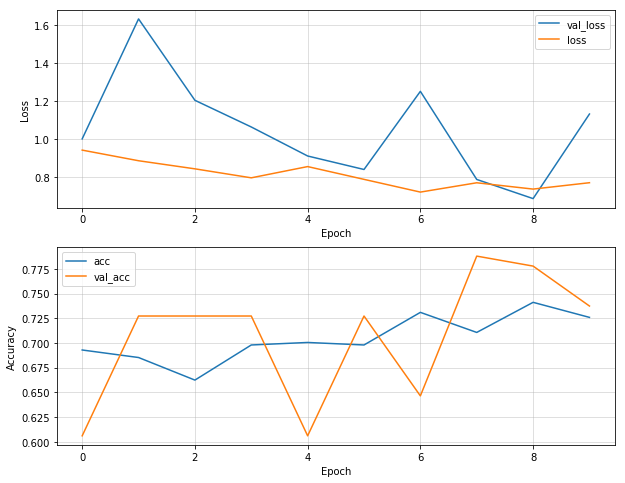

In [7]:
hist = acc_hist.history
f, ax = plt.subplots(2,1,figsize=(10,8))
for k in hist.keys():
    if 'loss' in k:
        ax[0].plot(hist[k], label=k)
    else:
        ax[1].plot(hist[k], label=k)
ylabels = ['Loss', 'Accuracy']
for i in range(2):
    ax[i].legend()
    ax[i].grid(alpha=0.5)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel('Epoch')


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


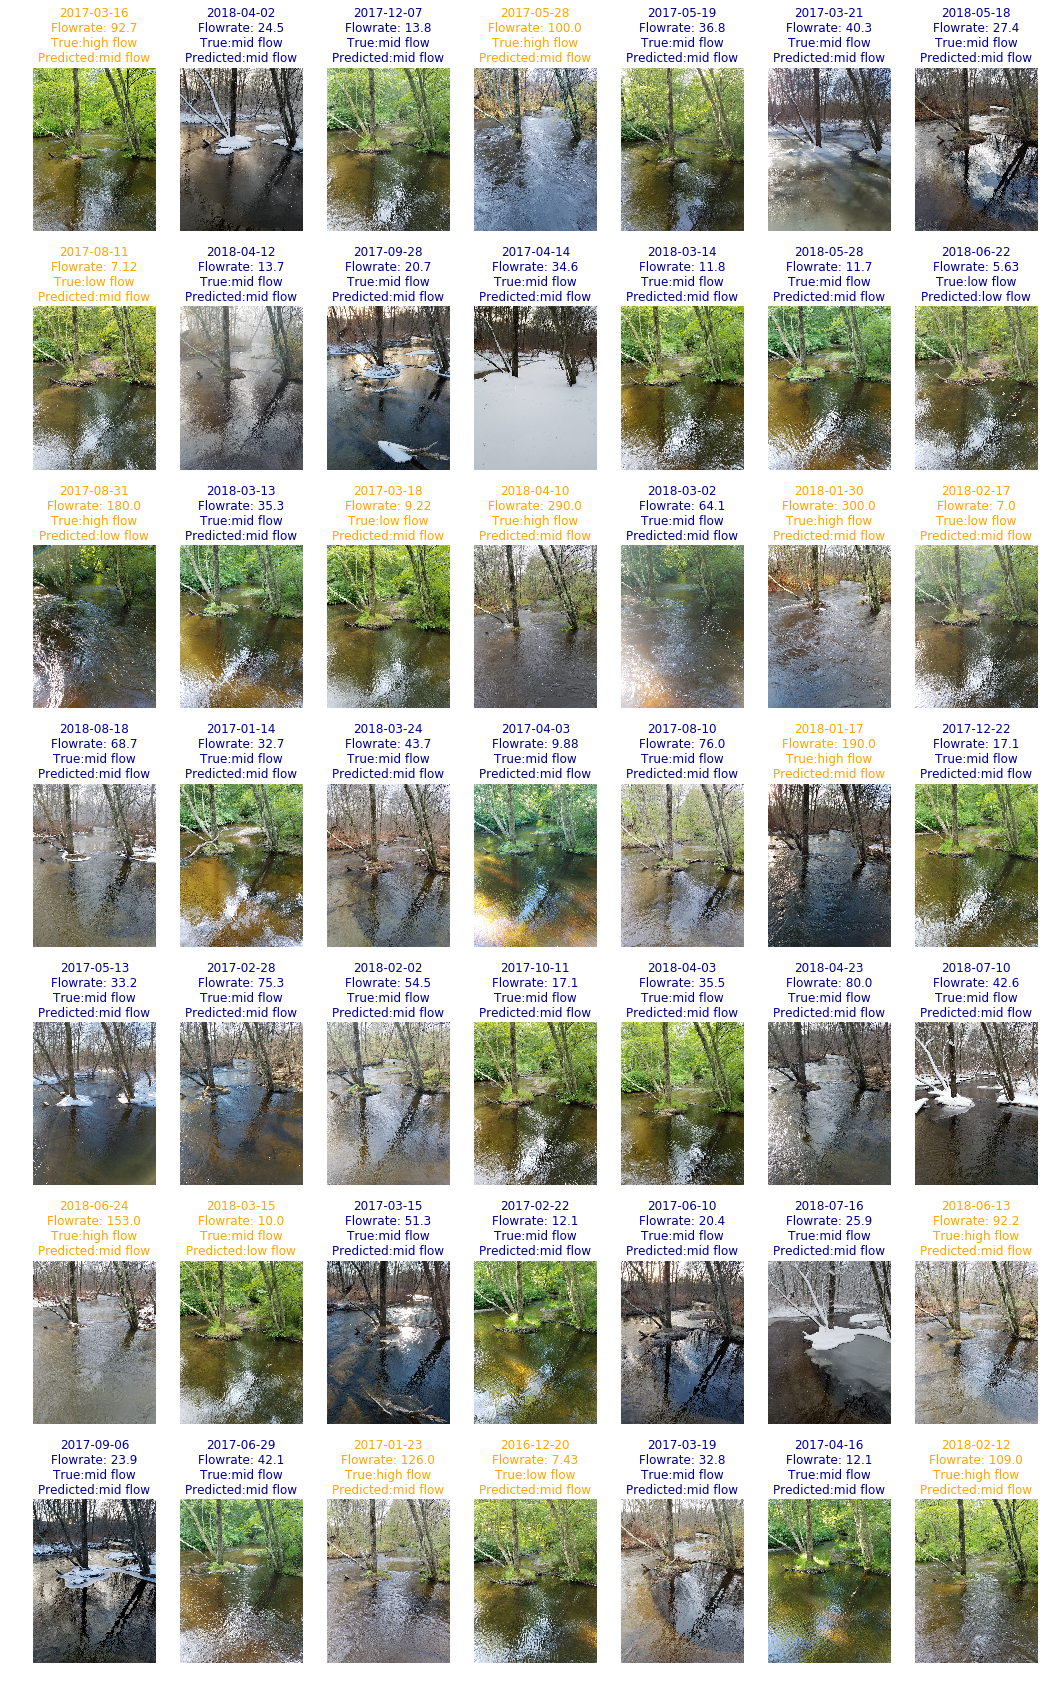

In [8]:
y_hat = model.predict(x_test)
ii = 7 
jj = 7
sample_i = np.random.choice(len(x_test), ii*jj, replace=False).reshape((ii,jj))
label = ['low flow','mid flow','high flow']
color = ['orange', 'darkblue']
f,ax = plt.subplots(ii, jj, figsize=(18,30))
for i in range(ii):
    for j in range(jj):
        s = sample_i[i][j]
        ax[i][j].imshow(x_test[s])
        ax[i][j].set_axis_off()
        ax[i][j].set_title('%s\nFlowrate: %s\nTrue:%s\nPredicted:%s'%(dates_test[s],y_test_flow[s],\
                                             label[np.argmax(y_test[s])],label[np.argmax(y_hat[s])]),\
                                                         color=color[np.argmax(y_test[s])==np.argmax(y_hat[s])])
        

Confusion matrix


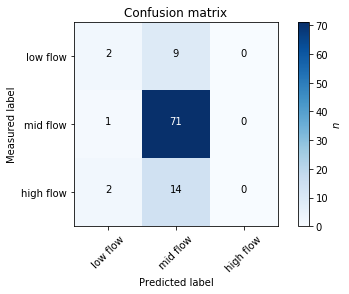

In [9]:
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_hat,axis=1))
plot_confusion_matrix(cm, classes=label)

In [ ]:
model_json = model.to_json()
with open("/contents/output/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/contents/output/model.h5")
print("Saved model to disk")
plot_model(model, to_file='/contents/output/model_graph.png')

In [ ]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(xtrain, yclass, batch_size=6, epochs=5, \
          class_weight=class_weights, validation_split=0.2, shuffle=True)
for layer in model.layers[:-3]: #unfreeze everything
    layer.trainable = True 
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(xtrain, yclass, batch_size=6, epochs=5, \
          class_weight=class_weights, validation_split=0.2, shuffle=True)

In [ ]:
i = 50 
test = model.predict(np.array([xtrain[i]]))
plt.imshow(xtrain[i])
print(ytrain[i], test[0][0])

In [ ]:
test = model.predict(xtrain)
plt.scatter(ytrain, test)
def R2(y_true, y_pred):
    u = np.sum(np.square(y_true - y_pred))
    v = np.sum(np.square(y_true - np.mean(y_true)))
    return(np.ones_like(v) - (u / v))
print(R2(ytrain,test))

In [ ]:
#maybe use an imagegenerator
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

def data_generator(x, y, batch_size=None):
    total_data_size = len(y)
    data_indices = np.arange(total_data_size)
    if batch_size is None:
        batch_size = total_data_size
    n_batches = total_data_size // batch_size
    batch_list = np.random.permutation(total_data_size)
    for b in range(n_batches):
        permut = batch_list[b*batch_size:((b+1)*batch_size)]
        x_batch = x[permut]
        y_batch = y[permut]
        yield(x_batch, y_batch)

def create_aug_gen(in_gen):
    for in_x, in_y in in_gen:
        g_x = image_gen.flow(255*in_x, in_y, batch_size=in_x.shape[0])
        x, y = next(g_x)
        yield x/255.0, y

In [ ]:
g = data_generator(xtrain, yclass, batch_size=5)
cur_gen = create_aug_gen(g)

In [ ]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit_generator(cur_gen, steps_per_epoch=len(ytrain)//5, class_weight=class_weights,\
                    epochs=10)